In [1]:
!pip install --quiet keras

# Transfer Learning with CNNS
Author: Derek Pyne

## 1) Downloading dataset
We'll use Tensorflows flower dataset. This dataset has 5 classes (Daisy, Dandelion, Rese, Sunflower, and Tulip). Images for each class are stored in its own folder.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import tarfile

In [3]:
url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
r = requests.get(url)
 
with open("data/flowers.tgz", "wb") as code:
  code.write(r.content)

In [4]:
with tarfile.open('data/flowers.tgz') as tgz:
  tgz.extractall(path='data')

## 2) Setup training/validation sets and image preprocessing pipeline

We can use a Keras DataGenerator to parse our directory structure and feed data into our model in batches. Although we could load this entire dataset easily into memory, this method is more scalable.

We use an ImageDataGenerator which lets us preprocess our images when they are read from disc. We will scale the input range and resize the image.

We'll also split our data into a training and validation set generators. Data is shuffled to even the distribution of labels in training and validation sets.

In [5]:
from keras.preprocessing.image import ImageDataGenerator
# Could try feature-wise center and normalization here
datagen = ImageDataGenerator(rescale=1./255, validation_split=.25) 

image_w, image_h = 150, 150
data_dir = 'data/flower_photos'
batch_size=32

train_generator = datagen.flow_from_directory(
    data_dir,
    shuffle=True,
    target_size=(image_h, image_w),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    data_dir, # same directory as training data
    shuffle=True,
    target_size=(image_h, image_w),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Using TensorFlow backend.


Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.


We can also sample one of our images to see what they look like and check that it was resized properly.

Label: 0


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


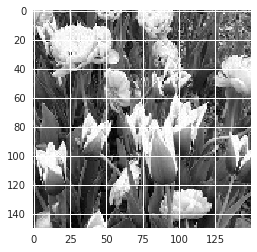

In [6]:
batch = train_generator.next()

image = batch[0][0]
label = batch[1][0]

plt.imshow(image[:,:,0], cmap=plt.get_cmap("gray"))
print("Label: %d" % label[0])
train_generator.reset()

## 3) Building Model

As our base model, we will use a VGG16 model (trained on Imagenet), without it's fully connected layers. Our own two fully connected layers are added.

In [7]:
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers

def vgg16_transfer_model():
  # VGG16 Model with defalut parameters
  base_model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))

  model = Sequential([
      base_model,
      Flatten(name='flatten'),
      Dense(256, activation='relu', name='fc'),
  #     Dropout(0.5),
      Dense(5, activation='softmax', name='predictions')
  ])
  return model
vgg16_transfer_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
fc (Dense)                   (None, 256)               2097408   
_________________________________________________________________
predictions (Dense)          (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 16,813,381
Non-trainable params: 0
_________________________________________________________________


## 4) Training
We'll now go through and test different variants of our model with different parts of the model frozen/trainable.

In [8]:
from keras.backend import tensorflow_backend
epochs = 20
tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Variant 1: Frozen VGG16 model, trainable FC layers

In [9]:
model_v1 = vgg16_transfer_model()
model_v1.layers[0].trainable = False
print(">>> Freezing VGG16")
for i, layer in enumerate(model_v1.layers):
    print(i, layer.name, layer.trainable)
    
model_v1.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
print(">>> Model summary")
model_v1.summary()

>>> Freezing VGG16
0 vgg16 False
1 flatten True
2 fc True
3 predictions True
>>> Model summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
fc (Dense)                   (None, 256)               2097408   
_________________________________________________________________
predictions (Dense)          (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
train_generator.reset()
validation_generator.reset()

model_v1.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs)

Epoch 1/20
86/86 [==============================] - 21s 245ms/step - loss: 1.5573 - acc: 0.3118 - val_loss: 1.4103 - val_acc: 0.4587
Epoch 2/20
86/86 [==============================] - 19s 220ms/step - loss: 1.2799 - acc: 0.5459 - val_loss: 1.2526 - val_acc: 0.5266
Epoch 3/20
86/86 [==============================] - 18s 208ms/step - loss: 1.1376 - acc: 0.6062 - val_loss: 1.1304 - val_acc: 0.6070
Epoch 4/20
86/86 [==============================] - 18s 208ms/step - loss: 1.0318 - acc: 0.6631 - val_loss: 1.0674 - val_acc: 0.6376
Epoch 5/20
86/86 [==============================] - 18s 209ms/step - loss: 0.9648 - acc: 0.6774 - val_loss: 1.0062 - val_acc: 0.6410
Epoch 6/20
86/86 [==============================] - 18s 209ms/step - loss: 0.8993 - acc: 0.7016 - val_loss: 0.9719 - val_acc: 0.6670
Epoch 7/20
86/86 [==============================] - 18s 209ms/step - loss: 0.8618 - acc: 0.7142 - val_loss: 0.9535 - val_acc: 0.6535
Epoch 8/20
86/86 [==============================] - 18s 209ms/step - 

### Variant 2: Frozen VGG16 model except last block (block5), trainable FC layers

In [11]:
model_v2 = vgg16_transfer_model()

print(">>> Freezing everything in VGG16 except block5")
for i, layer in enumerate(model_v2.layers[0].layers):
  if i < 14: 
    layer.trainable = False
  print(i, layer.name, layer.trainable)
  
model_v2.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
print(">>> Model summary")
model_v2.summary()

>>> Freezing everything in VGG16 except block5
0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
>>> Model summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
fc (Dense)                   (None, 256)               2097408   
_________________________________________________________________
predictions (D

In [12]:
train_generator.reset()
validation_generator.reset()

model_v2.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs)

Epoch 1/20
86/86 [==============================] - 21s 245ms/step - loss: 1.3774 - acc: 0.4525 - val_loss: 1.1578 - val_acc: 0.5603
Epoch 2/20
86/86 [==============================] - 20s 236ms/step - loss: 0.8830 - acc: 0.6980 - val_loss: 0.8685 - val_acc: 0.6682
Epoch 3/20
86/86 [==============================] - 20s 236ms/step - loss: 0.6428 - acc: 0.7796 - val_loss: 0.6818 - val_acc: 0.7486
Epoch 4/20
86/86 [==============================] - 20s 235ms/step - loss: 0.5213 - acc: 0.8208 - val_loss: 0.6561 - val_acc: 0.7463
Epoch 5/20
86/86 [==============================] - 20s 235ms/step - loss: 0.4393 - acc: 0.8554 - val_loss: 0.5874 - val_acc: 0.7792
Epoch 6/20
86/86 [==============================] - 20s 236ms/step - loss: 0.3904 - acc: 0.8812 - val_loss: 0.5773 - val_acc: 0.7848
Epoch 7/20
86/86 [==============================] - 20s 237ms/step - loss: 0.3280 - acc: 0.8972 - val_loss: 0.5161 - val_acc: 0.8029
Epoch 8/20
86/86 [==============================] - 20s 234ms/step - 

### Variant 3: All layers trainable

In [13]:
model_v3 = vgg16_transfer_model()
print(">>> All layers trainable")
for i, layer in enumerate(model_v3.layers):
    print(i, layer.name, layer.trainable)
    
model_v3.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
print(">>> Model summary")
model_v3.summary()

>>> All layers trainable
0 vgg16 True
1 flatten True
2 fc True
3 predictions True
>>> Model summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
fc (Dense)                   (None, 256)               2097408   
_________________________________________________________________
predictions (Dense)          (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 16,813,381
Non-trainable params: 0
_________________________________________________________________


In [14]:
train_generator.reset()
validation_generator.reset()

model_v3.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs)

Epoch 1/20
86/86 [==============================] - 47s 547ms/step - loss: 1.3678 - acc: 0.4661 - val_loss: 1.0030 - val_acc: 0.6116
Epoch 2/20
86/86 [==============================] - 43s 499ms/step - loss: 0.6817 - acc: 0.7623 - val_loss: 0.6394 - val_acc: 0.7735
Epoch 3/20
86/86 [==============================] - 43s 497ms/step - loss: 0.4473 - acc: 0.8470 - val_loss: 0.5642 - val_acc: 0.7928
Epoch 4/20
86/86 [==============================] - 43s 498ms/step - loss: 0.3450 - acc: 0.8751 - val_loss: 0.5201 - val_acc: 0.8075
Epoch 5/20
86/86 [==============================] - 43s 497ms/step - loss: 0.2879 - acc: 0.9048 - val_loss: 0.4988 - val_acc: 0.8211
Epoch 6/20
86/86 [==============================] - 43s 497ms/step - loss: 0.1979 - acc: 0.9324 - val_loss: 0.5349 - val_acc: 0.8211
Epoch 7/20
86/86 [==============================] - 43s 497ms/step - loss: 0.1626 - acc: 0.9451 - val_loss: 0.5289 - val_acc: 0.8177
Epoch 8/20
86/86 [==============================] - 43s 504ms/step - 

## 5) Outcomes

Validation set accuracy:
- Variant 1 (Only training FC layers): 72%
- Variant 2 (Training Block5 + FC layers): 82%
- Variant 3 (Training all layers): 84%

Training time (per epoch):
- Variant 1 (Only training FC layers): 18s
- Variant 2 (Training Block5 + FC layers): 20s
- Variant 3 (Training all layers): 43s

We can see that as we increased the number of trainable layers the accuracy increased along with the training time. Variant 2 was a nice middle ground with accuracy almost as high as Variant 3 but training time only marginally slower then Variant 1.

This makes sense as the models with more trainable parts are essentially higher capability and as long as we can keep them from overfitting our data, we expect them to perform better.